# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

#mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
#pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

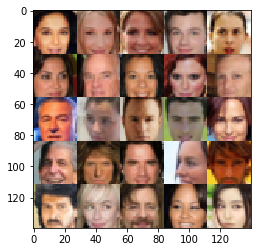

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_images')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data')
    learning_rate = tf.placeholder(tf.float32, None)
    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [55]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        def normalize(x):
            # batch
            x = tf.layers.batch_normalization(x, training=True)
            # max
            x = tf.maximum(alpha * x, x)
            # trying swish https://lazyprogrammer.me/deep-learning-the-swish-activation-function/
            # x = x * tf.sigmoid(tf.contrib.layers.bias_add(x))
            return x
        
        # TODO: Implement Function
        # input is 28x28x3
        # convd
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        # max
        x = tf.maximum(alpha * x, x)
    
        # 14x14x64
        # convd
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same', 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = normalize(x)
    
        # 7x7x128
        # convd
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same', 
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = normalize(x)
        # flatten
        # reshape
        x = tf.reshape(x, [-1, 4 * 4 * 256])
        x = tf.layers.dropout(x, rate=0.6)
        
        #dense logits
        logits = tf.layers.dense(x, 1)
        
        #sigmoid tensor
        response = tf.sigmoid(logits)
    
    return response, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [52]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        def normalize(x):
            x = tf.layers.batch_normalization(x, training=is_train)
            #x = tf.maximum(alpha * x, x) 
            x = tf.layers.dropout(x, rate=0.5, training=is_train)
            x = tf.nn.relu(x)
            # trying swish https://lazyprogrammer.me/deep-learning-the-swish-activation-function/
            # I got it working, but I wasn't sure how it would align with grading so switched back.
            # Although swish seemed to produce better images.
            #x = x * tf.sigmoid(tf.contrib.layers.bias_add(x))
            # x = x * tf.sigmoid(x)
            return x
        
        # TODO: Implement Function
        # fully connected layer.
        # 4x4x1028
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = normalize(x)
        # 7x7x512
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding='same', 
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = normalize(x)
        # 14x14x256
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same', 
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = normalize(x)
        # 28x28x3
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    real_model, real_logits = discriminator(input_real)
    fake_model, fake_logits = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_model)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_model)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_model)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [26]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vars = tf.trainable_variables()
    d_vars = []
    g_vars = []
    for var in vars:
        if var.name.startswith('discriminator'):
            d_vars.append(var)
        if var.name.startswith('generator'):
            g_vars.append(var)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1= beta1).minimize(
            d_loss, var_list=d_vars)
        
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1= beta1).minimize(
            g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [27]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [57]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, 
          data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    data_used = "MNIST" if data_image_mode=="L" else "CelebA"
    steps = 0
    image_width, image_height, image_channels = data_shape[1:]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    save_loc = "facegan/{}/{}".format(data_used, int(time.time()))
    print (save_loc)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                
                # Noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                feed = {lr: learning_rate, input_real: batch_images, input_z: batch_z}
                _ = sess.run(d_train_opt, feed_dict=feed)
                _ = sess.run(g_train_opt, feed_dict=feed)
                _ = sess.run(d_train_opt, feed_dict=feed)
                _ = sess.run(g_train_opt, feed_dict=feed)
                _ = sess.run(g_train_opt, feed_dict=feed)
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
        saver.save(sess, save_dir, global_step=epoch_i)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

facegan/MNIST/1509399572
Epoch 1/2... Discriminator Loss: 1.8394... Generator Loss: 0.2142
Epoch 1/2... Discriminator Loss: 0.3827... Generator Loss: 1.8145
Epoch 1/2... Discriminator Loss: 0.3860... Generator Loss: 1.4690
Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 1.2496
Epoch 1/2... Discriminator Loss: 0.7039... Generator Loss: 2.2071
Epoch 1/2... Discriminator Loss: 1.1667... Generator Loss: 1.3158
Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 1.5278
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 2.1126
Epoch 1/2... Discriminator Loss: 0.7190... Generator Loss: 1.4710
Epoch 1/2... Discriminator Loss: 0.7010... Generator Loss: 1.2891


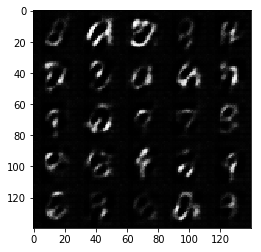

Epoch 1/2... Discriminator Loss: 0.7831... Generator Loss: 1.4370
Epoch 1/2... Discriminator Loss: 0.8553... Generator Loss: 1.5097
Epoch 1/2... Discriminator Loss: 0.8113... Generator Loss: 1.6287
Epoch 1/2... Discriminator Loss: 0.6633... Generator Loss: 1.3935
Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 1.2392
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.0936
Epoch 1/2... Discriminator Loss: 0.7843... Generator Loss: 1.1286
Epoch 1/2... Discriminator Loss: 0.8180... Generator Loss: 1.4289
Epoch 1/2... Discriminator Loss: 0.7395... Generator Loss: 1.3179
Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 1.7512


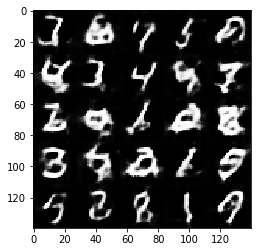

Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 1.3063
Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 1.4642
Epoch 1/2... Discriminator Loss: 0.9089... Generator Loss: 1.6905
Epoch 1/2... Discriminator Loss: 0.9096... Generator Loss: 1.5305
Epoch 1/2... Discriminator Loss: 0.8935... Generator Loss: 1.5058
Epoch 1/2... Discriminator Loss: 0.9055... Generator Loss: 1.4030
Epoch 1/2... Discriminator Loss: 0.8749... Generator Loss: 1.4483
Epoch 1/2... Discriminator Loss: 0.8845... Generator Loss: 1.7214
Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 1.6399
Epoch 1/2... Discriminator Loss: 0.8891... Generator Loss: 1.6268


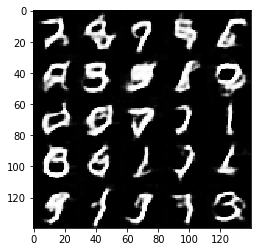

Epoch 1/2... Discriminator Loss: 0.8451... Generator Loss: 1.2751
Epoch 1/2... Discriminator Loss: 0.8290... Generator Loss: 1.3725
Epoch 1/2... Discriminator Loss: 0.7668... Generator Loss: 1.3899
Epoch 1/2... Discriminator Loss: 0.8617... Generator Loss: 1.1914
Epoch 1/2... Discriminator Loss: 0.8469... Generator Loss: 1.5702
Epoch 1/2... Discriminator Loss: 0.8474... Generator Loss: 1.3375
Epoch 1/2... Discriminator Loss: 0.8737... Generator Loss: 1.6934
Epoch 1/2... Discriminator Loss: 0.7903... Generator Loss: 1.2572
Epoch 1/2... Discriminator Loss: 0.8516... Generator Loss: 1.4763
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.4918


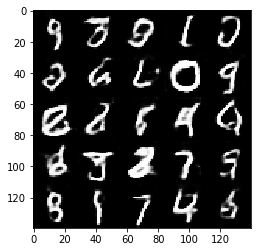

Epoch 1/2... Discriminator Loss: 0.6897... Generator Loss: 1.2073
Epoch 1/2... Discriminator Loss: 0.8244... Generator Loss: 1.2263
Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 0.8027... Generator Loss: 1.7033
Epoch 1/2... Discriminator Loss: 0.7014... Generator Loss: 1.3198
Epoch 1/2... Discriminator Loss: 0.7650... Generator Loss: 1.4803
Epoch 1/2... Discriminator Loss: 0.8642... Generator Loss: 1.2180
Epoch 1/2... Discriminator Loss: 0.9081... Generator Loss: 0.9348
Epoch 1/2... Discriminator Loss: 0.7509... Generator Loss: 1.3678
Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 1.4349


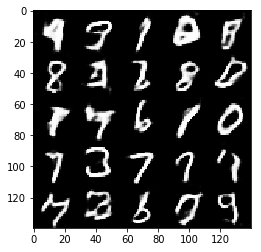

Epoch 1/2... Discriminator Loss: 0.6976... Generator Loss: 1.4187
Epoch 1/2... Discriminator Loss: 0.9256... Generator Loss: 1.3073
Epoch 1/2... Discriminator Loss: 0.6427... Generator Loss: 1.2726
Epoch 1/2... Discriminator Loss: 0.7362... Generator Loss: 1.5657
Epoch 1/2... Discriminator Loss: 0.9123... Generator Loss: 1.8460
Epoch 1/2... Discriminator Loss: 0.7422... Generator Loss: 1.1019
Epoch 1/2... Discriminator Loss: 0.5731... Generator Loss: 1.5663
Epoch 1/2... Discriminator Loss: 0.7849... Generator Loss: 1.7463
Epoch 1/2... Discriminator Loss: 0.6509... Generator Loss: 1.2984
Epoch 1/2... Discriminator Loss: 0.6356... Generator Loss: 1.6960


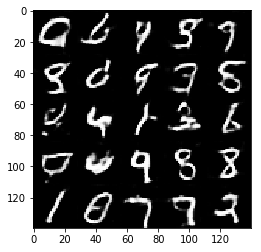

Epoch 1/2... Discriminator Loss: 0.6546... Generator Loss: 1.4939
Epoch 1/2... Discriminator Loss: 0.6012... Generator Loss: 1.6122
Epoch 1/2... Discriminator Loss: 0.7820... Generator Loss: 1.2347
Epoch 1/2... Discriminator Loss: 0.5525... Generator Loss: 1.4689
Epoch 1/2... Discriminator Loss: 0.6297... Generator Loss: 1.4700
Epoch 1/2... Discriminator Loss: 0.5917... Generator Loss: 1.5057
Epoch 1/2... Discriminator Loss: 0.6088... Generator Loss: 1.3493
Epoch 1/2... Discriminator Loss: 0.5586... Generator Loss: 1.4742
Epoch 1/2... Discriminator Loss: 0.5154... Generator Loss: 1.6572
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 2.5990


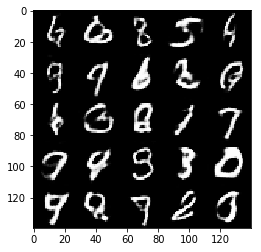

Epoch 1/2... Discriminator Loss: 0.5299... Generator Loss: 1.5067
Epoch 1/2... Discriminator Loss: 0.6315... Generator Loss: 1.7602
Epoch 1/2... Discriminator Loss: 0.5571... Generator Loss: 1.3557
Epoch 1/2... Discriminator Loss: 0.4669... Generator Loss: 2.2588
Epoch 1/2... Discriminator Loss: 0.4072... Generator Loss: 1.8486
Epoch 1/2... Discriminator Loss: 1.7322... Generator Loss: 2.4144
Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 1.5539
Epoch 1/2... Discriminator Loss: 0.4695... Generator Loss: 1.4904
Epoch 1/2... Discriminator Loss: 0.5832... Generator Loss: 2.2168
Epoch 1/2... Discriminator Loss: 0.6654... Generator Loss: 1.7366


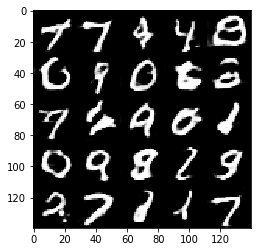

Epoch 1/2... Discriminator Loss: 0.3912... Generator Loss: 1.7961
Epoch 1/2... Discriminator Loss: 0.4050... Generator Loss: 1.9438
Epoch 1/2... Discriminator Loss: 0.4740... Generator Loss: 2.0525
Epoch 1/2... Discriminator Loss: 0.4507... Generator Loss: 1.5461
Epoch 1/2... Discriminator Loss: 0.8839... Generator Loss: 2.2794
Epoch 1/2... Discriminator Loss: 0.4857... Generator Loss: 1.9623
Epoch 1/2... Discriminator Loss: 0.3717... Generator Loss: 1.7997
Epoch 1/2... Discriminator Loss: 0.6897... Generator Loss: 2.2479
Epoch 1/2... Discriminator Loss: 0.4174... Generator Loss: 2.0229
Epoch 1/2... Discriminator Loss: 0.4694... Generator Loss: 2.5333


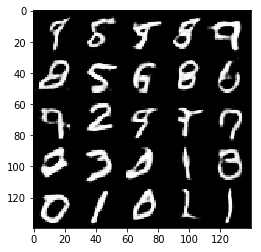

Epoch 1/2... Discriminator Loss: 0.4669... Generator Loss: 1.2714
Epoch 1/2... Discriminator Loss: 0.3125... Generator Loss: 1.9958
Epoch 1/2... Discriminator Loss: 0.5908... Generator Loss: 1.7536
Epoch 2/2... Discriminator Loss: 0.4164... Generator Loss: 1.7801
Epoch 2/2... Discriminator Loss: 0.4131... Generator Loss: 1.9090
Epoch 2/2... Discriminator Loss: 0.4192... Generator Loss: 1.6496
Epoch 2/2... Discriminator Loss: 0.2617... Generator Loss: 2.1264
Epoch 2/2... Discriminator Loss: 0.3520... Generator Loss: 1.6846
Epoch 2/2... Discriminator Loss: 0.4782... Generator Loss: 2.2822
Epoch 2/2... Discriminator Loss: 0.3667... Generator Loss: 1.8835


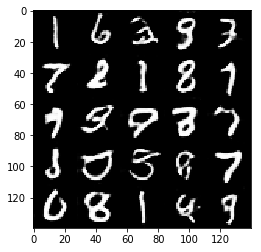

Epoch 2/2... Discriminator Loss: 0.2383... Generator Loss: 2.4819
Epoch 2/2... Discriminator Loss: 0.4195... Generator Loss: 2.1421
Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.8226
Epoch 2/2... Discriminator Loss: 0.5906... Generator Loss: 1.5702
Epoch 2/2... Discriminator Loss: 0.4382... Generator Loss: 2.4140
Epoch 2/2... Discriminator Loss: 0.3922... Generator Loss: 2.0356
Epoch 2/2... Discriminator Loss: 0.3790... Generator Loss: 2.3520
Epoch 2/2... Discriminator Loss: 0.3187... Generator Loss: 1.8174
Epoch 2/2... Discriminator Loss: 0.6764... Generator Loss: 1.9086
Epoch 2/2... Discriminator Loss: 0.5499... Generator Loss: 2.5991


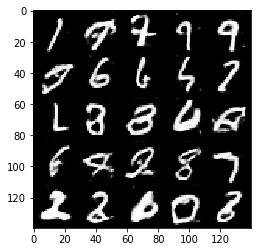

Epoch 2/2... Discriminator Loss: 0.3823... Generator Loss: 2.4627
Epoch 2/2... Discriminator Loss: 0.3276... Generator Loss: 1.5181
Epoch 2/2... Discriminator Loss: 0.2609... Generator Loss: 2.8470
Epoch 2/2... Discriminator Loss: 0.2982... Generator Loss: 2.0263
Epoch 2/2... Discriminator Loss: 0.3433... Generator Loss: 2.8509
Epoch 2/2... Discriminator Loss: 0.2691... Generator Loss: 2.8724
Epoch 2/2... Discriminator Loss: 0.2333... Generator Loss: 2.5846
Epoch 2/2... Discriminator Loss: 0.2998... Generator Loss: 2.3597
Epoch 2/2... Discriminator Loss: 0.2752... Generator Loss: 3.1308
Epoch 2/2... Discriminator Loss: 0.4538... Generator Loss: 2.0790


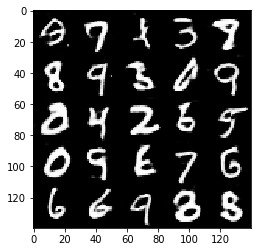

Epoch 2/2... Discriminator Loss: 0.2762... Generator Loss: 2.3789
Epoch 2/2... Discriminator Loss: 0.2755... Generator Loss: 3.1918
Epoch 2/2... Discriminator Loss: 0.5739... Generator Loss: 1.9055
Epoch 2/2... Discriminator Loss: 0.5320... Generator Loss: 2.7869
Epoch 2/2... Discriminator Loss: 0.2965... Generator Loss: 2.3307
Epoch 2/2... Discriminator Loss: 0.2678... Generator Loss: 2.0167
Epoch 2/2... Discriminator Loss: 0.1956... Generator Loss: 2.8947
Epoch 2/2... Discriminator Loss: 0.2167... Generator Loss: 2.2560
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 4.2781
Epoch 2/2... Discriminator Loss: 0.4780... Generator Loss: 2.0470


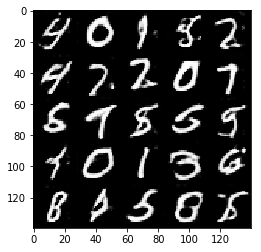

Epoch 2/2... Discriminator Loss: 0.3296... Generator Loss: 1.9438
Epoch 2/2... Discriminator Loss: 0.2635... Generator Loss: 2.3407
Epoch 2/2... Discriminator Loss: 0.2810... Generator Loss: 2.6283
Epoch 2/2... Discriminator Loss: 0.2995... Generator Loss: 2.3969
Epoch 2/2... Discriminator Loss: 0.2460... Generator Loss: 2.1187
Epoch 2/2... Discriminator Loss: 0.1901... Generator Loss: 2.9593
Epoch 2/2... Discriminator Loss: 0.3893... Generator Loss: 2.4920
Epoch 2/2... Discriminator Loss: 0.2201... Generator Loss: 2.8312
Epoch 2/2... Discriminator Loss: 0.1850... Generator Loss: 2.3274
Epoch 2/2... Discriminator Loss: 0.3435... Generator Loss: 2.9677


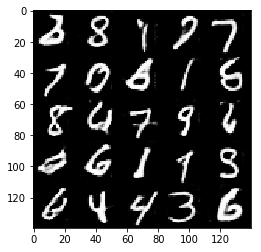

Epoch 2/2... Discriminator Loss: 0.2430... Generator Loss: 3.3448
Epoch 2/2... Discriminator Loss: 0.2071... Generator Loss: 2.3908
Epoch 2/2... Discriminator Loss: 0.1811... Generator Loss: 2.2909
Epoch 2/2... Discriminator Loss: 0.1814... Generator Loss: 2.6705
Epoch 2/2... Discriminator Loss: 0.5310... Generator Loss: 1.7815
Epoch 2/2... Discriminator Loss: 0.3023... Generator Loss: 2.2570
Epoch 2/2... Discriminator Loss: 0.2520... Generator Loss: 2.3141
Epoch 2/2... Discriminator Loss: 0.4301... Generator Loss: 2.6356
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.5259
Epoch 2/2... Discriminator Loss: 0.2656... Generator Loss: 2.4030


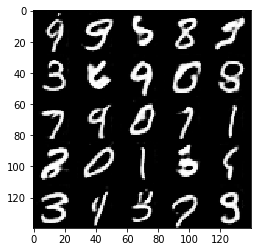

Epoch 2/2... Discriminator Loss: 0.2375... Generator Loss: 2.3401
Epoch 2/2... Discriminator Loss: 0.3026... Generator Loss: 2.9807
Epoch 2/2... Discriminator Loss: 0.1829... Generator Loss: 3.1223
Epoch 2/2... Discriminator Loss: 0.2030... Generator Loss: 3.0915
Epoch 2/2... Discriminator Loss: 0.1772... Generator Loss: 2.7628
Epoch 2/2... Discriminator Loss: 0.7563... Generator Loss: 3.8309
Epoch 2/2... Discriminator Loss: 0.1797... Generator Loss: 2.9029
Epoch 2/2... Discriminator Loss: 0.1770... Generator Loss: 2.5288
Epoch 2/2... Discriminator Loss: 0.2005... Generator Loss: 2.3197
Epoch 2/2... Discriminator Loss: 0.1871... Generator Loss: 2.8380


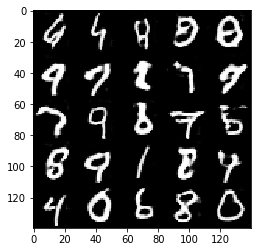

Epoch 2/2... Discriminator Loss: 0.1277... Generator Loss: 3.1151
Epoch 2/2... Discriminator Loss: 0.1528... Generator Loss: 2.8172
Epoch 2/2... Discriminator Loss: 0.1242... Generator Loss: 3.4075
Epoch 2/2... Discriminator Loss: 0.1501... Generator Loss: 2.5326
Epoch 2/2... Discriminator Loss: 0.6815... Generator Loss: 2.8933
Epoch 2/2... Discriminator Loss: 0.4067... Generator Loss: 1.8053
Epoch 2/2... Discriminator Loss: 0.1632... Generator Loss: 2.6852
Epoch 2/2... Discriminator Loss: 0.2979... Generator Loss: 3.6207
Epoch 2/2... Discriminator Loss: 0.1581... Generator Loss: 2.6586
Epoch 2/2... Discriminator Loss: 0.1323... Generator Loss: 3.3266


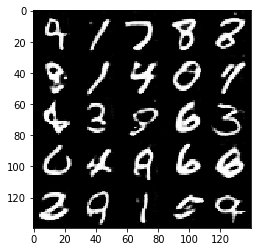

Epoch 2/2... Discriminator Loss: 0.1966... Generator Loss: 2.3144
Epoch 2/2... Discriminator Loss: 0.1315... Generator Loss: 2.7913
Epoch 2/2... Discriminator Loss: 0.1107... Generator Loss: 2.8955
Epoch 2/2... Discriminator Loss: 0.1569... Generator Loss: 4.0871
Epoch 2/2... Discriminator Loss: 0.7727... Generator Loss: 2.1803
Epoch 2/2... Discriminator Loss: 0.4055... Generator Loss: 2.5774
Epoch 2/2... Discriminator Loss: 0.2131... Generator Loss: 3.7431
Epoch 2/2... Discriminator Loss: 0.1687... Generator Loss: 2.2776
Epoch 2/2... Discriminator Loss: 0.2014... Generator Loss: 2.9534
Epoch 2/2... Discriminator Loss: 0.1538... Generator Loss: 2.7002


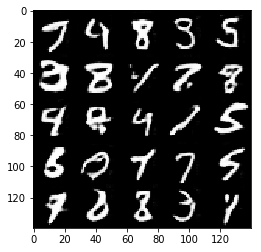

Epoch 2/2... Discriminator Loss: 0.1470... Generator Loss: 2.7057
Epoch 2/2... Discriminator Loss: 0.2322... Generator Loss: 2.1268
Epoch 2/2... Discriminator Loss: 0.1373... Generator Loss: 2.1335
Epoch 2/2... Discriminator Loss: 0.1414... Generator Loss: 3.6970
Epoch 2/2... Discriminator Loss: 0.1102... Generator Loss: 2.8683
Epoch 2/2... Discriminator Loss: 0.1915... Generator Loss: 2.7841
Epoch 2/2... Discriminator Loss: 0.7127... Generator Loss: 2.2946


NameError: name 'saver' is not defined

In [56]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

facegan/CelebA/1509401707
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 0.2731... Generator Loss: 2.1193
Epoch 1/1... Discriminator Loss: 0.3099... Generator Loss: 1.6519
Epoch 1/1... Discriminator Loss: 0.5963... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 2.0504
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 1.6898
Epoch 1/1... Discriminator Loss: 0.1955... Generator Loss: 5.9800
Epoch 1/1... Discriminator Loss: 0.3247... Generator Loss: 1.9192


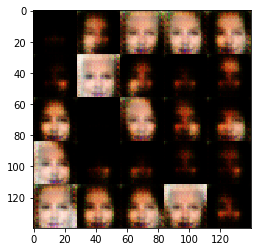

Epoch 1/1... Discriminator Loss: 0.3761... Generator Loss: 1.3918
Epoch 1/1... Discriminator Loss: 0.3719... Generator Loss: 4.6520
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 2.6399
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 1.5041
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.1315
Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 2.0269
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 1.7544
Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 3.1537


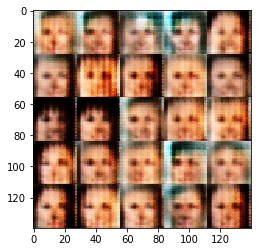

Epoch 1/1... Discriminator Loss: 2.1104... Generator Loss: 0.2776
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.3911
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.4485
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.4541
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.5908


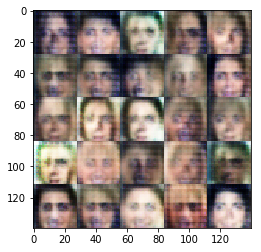

Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 1.0709
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.5467
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.4721


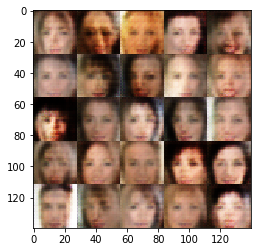

Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.5825


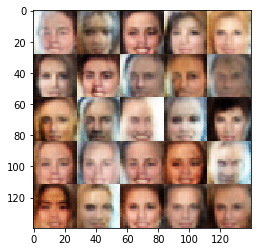

Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.4714
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.5936


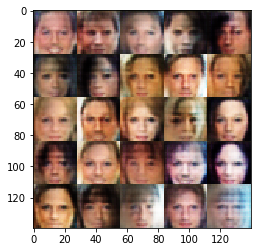

Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.2941... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 1.1608
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 1.0166... Generator Loss: 1.3592
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.1415
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.4559


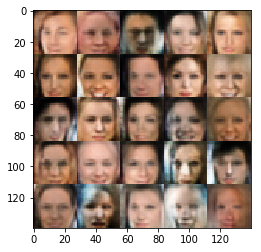

Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 0.9402... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 0.9735


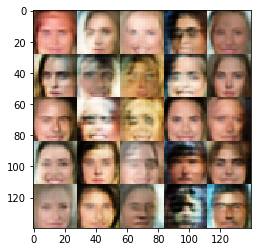

Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 1.1524
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 1.3758
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 0.9239


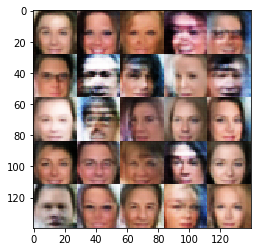

Epoch 1/1... Discriminator Loss: 0.9660... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.1121
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 0.9191... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.0171... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 1.2012


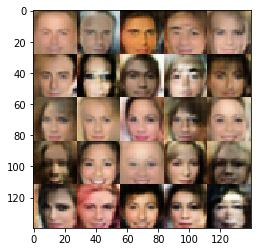

Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.0200
Epoch 1/1... Discriminator Loss: 0.9478... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.4513
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.1470
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.2146
Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.6317
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 0.9981
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.3115
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 1.2234


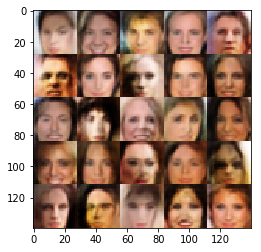

Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.4620
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.2879


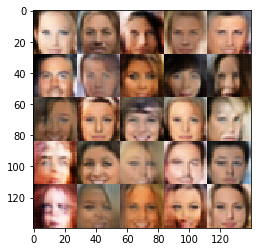

Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.3326
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.1030
Epoch 1/1... Discriminator Loss: 0.8832... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 0.8479


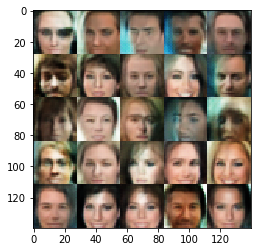

Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.5663
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.3655
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.1084


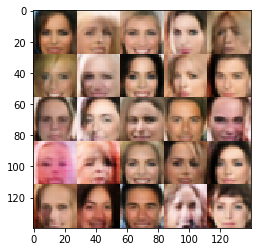

Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.4933
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 1.8649
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.4202
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.1494
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.1208


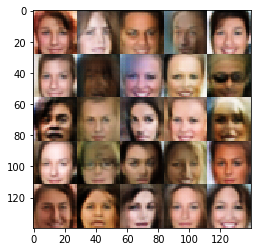

Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.4322
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.4444
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 1.2639
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 0.9217... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.2314


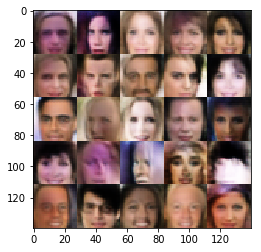

Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 0.8552... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.1802
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.1931
Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.2673
Epoch 1/1... Discriminator Loss: 0.7382... Generator Loss: 1.3457
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.2064
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.1694
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 1.2454


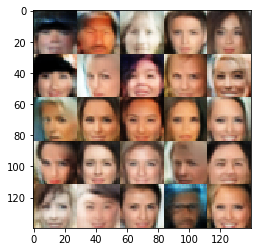

Epoch 1/1... Discriminator Loss: 0.6581... Generator Loss: 1.5321
Epoch 1/1... Discriminator Loss: 0.6501... Generator Loss: 1.3918
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 1.3050
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.0715
Epoch 1/1... Discriminator Loss: 0.9211... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 1.3931
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 1.3963


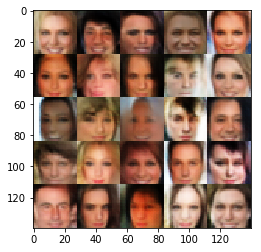

Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.4825
Epoch 1/1... Discriminator Loss: 0.7796... Generator Loss: 1.2083
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 0.5433... Generator Loss: 1.4333
Epoch 1/1... Discriminator Loss: 0.7568... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.3952
Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.4033
Epoch 1/1... Discriminator Loss: 0.6313... Generator Loss: 1.4144


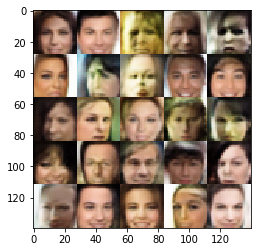

Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.7904
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 1.3948
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 2.1634
Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.6820
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.6158


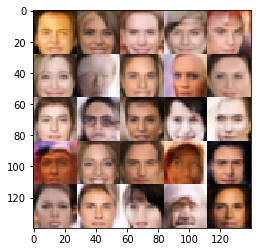

Epoch 1/1... Discriminator Loss: 0.7131... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.3029
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.1842
Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.5818
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.5417
Epoch 1/1... Discriminator Loss: 0.7927... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.9948
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 0.7344... Generator Loss: 1.3557


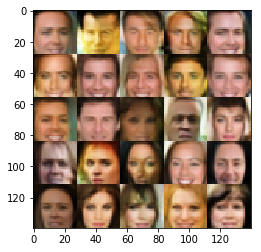

Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 1.5277
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.5968
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 2.4442
Epoch 1/1... Discriminator Loss: 0.5975... Generator Loss: 1.7205
Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 1.8521
Epoch 1/1... Discriminator Loss: 0.6594... Generator Loss: 1.3673
Epoch 1/1... Discriminator Loss: 0.6362... Generator Loss: 1.4093
Epoch 1/1... Discriminator Loss: 0.6924... Generator Loss: 1.8018
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 2.0350


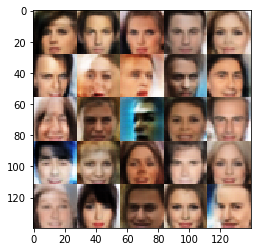

Epoch 1/1... Discriminator Loss: 0.6176... Generator Loss: 1.5268
Epoch 1/1... Discriminator Loss: 0.5953... Generator Loss: 2.0558
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 0.4970... Generator Loss: 1.6202
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 1.4202
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 1.6386
Epoch 1/1... Discriminator Loss: 0.4696... Generator Loss: 1.3016
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 1.5778


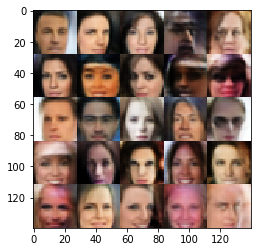

Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 1.5402
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 1.4802
Epoch 1/1... Discriminator Loss: 0.8183... Generator Loss: 1.7796
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 0.5115... Generator Loss: 1.6027
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 1.3582
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 1.8351
Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 1.6073


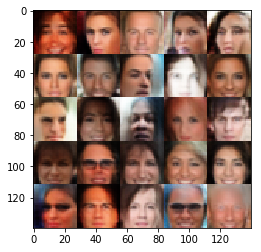

Epoch 1/1... Discriminator Loss: 0.5508... Generator Loss: 1.7660
Epoch 1/1... Discriminator Loss: 0.6487... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 1.4059
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 2.2049
Epoch 1/1... Discriminator Loss: 0.5663... Generator Loss: 1.6471
Epoch 1/1... Discriminator Loss: 0.6368... Generator Loss: 2.0658
Epoch 1/1... Discriminator Loss: 0.6397... Generator Loss: 1.4636
Epoch 1/1... Discriminator Loss: 0.5333... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 1.4372
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 1.6045


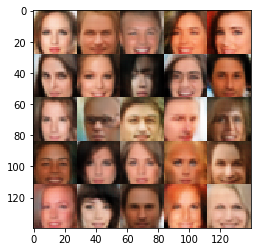

Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 1.3162
Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 1.8018
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 2.6436
Epoch 1/1... Discriminator Loss: 0.5249... Generator Loss: 1.6126
Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 1.5482
Epoch 1/1... Discriminator Loss: 0.4277... Generator Loss: 1.7272
Epoch 1/1... Discriminator Loss: 0.5019... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 0.4127... Generator Loss: 1.9207
Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 2.2658
Epoch 1/1... Discriminator Loss: 0.5275... Generator Loss: 1.1999


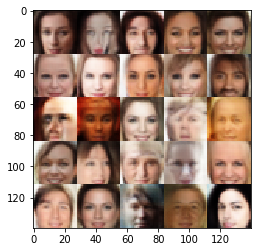

Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.7289
Epoch 1/1... Discriminator Loss: 0.4590... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 1.9646
Epoch 1/1... Discriminator Loss: 0.4446... Generator Loss: 1.3711
Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 1.7734
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 1.5167
Epoch 1/1... Discriminator Loss: 0.3875... Generator Loss: 1.7782
Epoch 1/1... Discriminator Loss: 0.4396... Generator Loss: 1.7674
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 2.3026
Epoch 1/1... Discriminator Loss: 0.5708... Generator Loss: 1.7748


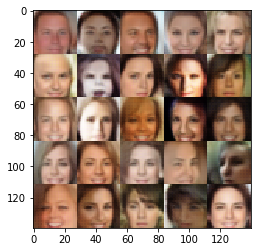

Epoch 1/1... Discriminator Loss: 0.4539... Generator Loss: 1.5679
Epoch 1/1... Discriminator Loss: 0.5631... Generator Loss: 1.6415
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 1.5534
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 2.1747
Epoch 1/1... Discriminator Loss: 0.5701... Generator Loss: 1.5292
Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 1.5227
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 1.7514
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 2.2093
Epoch 1/1... Discriminator Loss: 0.4499... Generator Loss: 1.9710
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 1.2657


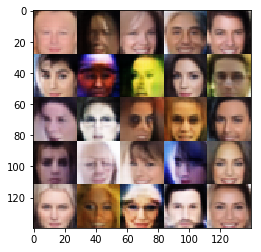

Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 2.3171
Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 2.4019
Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 2.1694
Epoch 1/1... Discriminator Loss: 0.3743... Generator Loss: 2.1243
Epoch 1/1... Discriminator Loss: 0.4902... Generator Loss: 2.4162
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 2.3577
Epoch 1/1... Discriminator Loss: 0.5236... Generator Loss: 1.6998
Epoch 1/1... Discriminator Loss: 0.7370... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 2.0351


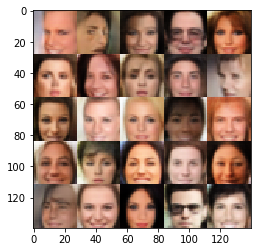

Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 1.9145
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 2.0788
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.5261
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 1.8471
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 1.9542
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 0.3077... Generator Loss: 2.0662
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 1.8985
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 2.4318
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 2.2396


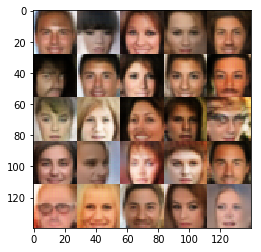

Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 2.5436
Epoch 1/1... Discriminator Loss: 0.3855... Generator Loss: 1.8314
Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 2.1804
Epoch 1/1... Discriminator Loss: 0.3438... Generator Loss: 2.3585
Epoch 1/1... Discriminator Loss: 0.4099... Generator Loss: 2.3058
Epoch 1/1... Discriminator Loss: 0.4925... Generator Loss: 2.6161
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 1.9019
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 2.1348
Epoch 1/1... Discriminator Loss: 0.5073... Generator Loss: 1.7908
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 1.6988


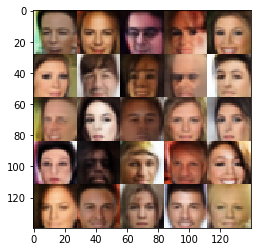

Epoch 1/1... Discriminator Loss: 0.4932... Generator Loss: 2.2392
Epoch 1/1... Discriminator Loss: 0.4131... Generator Loss: 1.7183
Epoch 1/1... Discriminator Loss: 0.3751... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 0.3567... Generator Loss: 2.3131
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 2.3161
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 1.4155


NameError: name 'save_dir' is not defined

In [58]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.